<a href="https://colab.research.google.com/github/GiridharaSPK/text-to-image-using-GANs/blob/master/GAN_MNIST_Word_to_Number_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

In [ ]:
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

K.set_image_dim_ordering('th')

# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.


# np.random.seed(1000)


Using TensorFlow backend.


In [ ]:
from __future__ import print_function


american_number_system = {
    'zero': 0,
    'one': 1,
    'two': 2,
    'three': 3,
    'four': 4,
    'five': 5,
    'six': 6,
    'seven': 7,
    'eight': 8,
    'nine': 9,
    'ten': 10,
    'eleven': 11,
    'twelve': 12,
    'thirteen': 13,
    'fourteen': 14,
    'fifteen': 15,
    'sixteen': 16,
    'seventeen': 17,
    'eighteen': 18,
    'nineteen': 19,
    'twenty': 20,
    'thirty': 30,
    'forty': 40,
    'fifty': 50,
    'sixty': 60,
    'seventy': 70,
    'eighty': 80,
    'ninety': 90,
    'hundred': 100,
    'thousand': 1000,
    'million': 1000000,
    'billion': 1000000000,
    'point': '.'
}

decimal_words = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']



def number_formation(number_words):
    numbers = []
    for number_word in number_words:
        numbers.append(american_number_system[number_word])
    if len(numbers) == 4:
        return (numbers[0] * numbers[1]) + numbers[2] + numbers[3]
    elif len(numbers) == 3:
        return numbers[0] * numbers[1] + numbers[2]
    elif len(numbers) == 2:
        if 100 in numbers:
            return numbers[0] * numbers[1]
        else:
            return numbers[0] + numbers[1]
    else:
        return numbers[0]





def get_decimal_sum(decimal_digit_words):
    decimal_number_str = []
    for dec_word in decimal_digit_words:
        if(dec_word not in decimal_words):
            return 0
        else:
            decimal_number_str.append(american_number_system[dec_word])
    final_decimal_string = '0.' + ''.join(map(str,decimal_number_str))
    return float(final_decimal_string)


"""
function to return integer for an input `number_sentence` string
input: string
output: int or double or None
"""


def word_to_num(number_sentence):
    if type(number_sentence) is not str:
        raise ValueError("Type of input is not string! Please enter a valid number word (eg. \'two million twenty three thousand and forty nine\')")

    number_sentence = number_sentence.replace('-', ' ')
    number_sentence = number_sentence.lower()  # converting input to lowercase

    if(number_sentence.isdigit()):  # return the number if user enters a number string
        return int(number_sentence)

    split_words = number_sentence.strip().split()  # strip extra spaces and split sentence into words

    clean_numbers = []
    clean_decimal_numbers = []

    # removing and, & etc.
    for word in split_words:
        if word in american_number_system:
            clean_numbers.append(word)

    # Error message if the user enters invalid input!
    if len(clean_numbers) == 0:
        raise ValueError("No valid number words found! Please enter a valid number word (eg. two million twenty three thousand and forty nine)") 

    # Error if user enters million,billion, thousand or decimal point twice
    if clean_numbers.count('thousand') > 1 or clean_numbers.count('million') > 1 or clean_numbers.count('billion') > 1 or clean_numbers.count('point')> 1:
        raise ValueError("Redundant number word! Please enter a valid number word (eg. two million twenty three thousand and forty nine)")

    # separate decimal part of number (if exists)
    if clean_numbers.count('point') == 1:
        clean_decimal_numbers = clean_numbers[clean_numbers.index('point')+1:]
        clean_numbers = clean_numbers[:clean_numbers.index('point')]

    billion_index = clean_numbers.index('billion') if 'billion' in clean_numbers else -1
    million_index = clean_numbers.index('million') if 'million' in clean_numbers else -1
    thousand_index = clean_numbers.index('thousand') if 'thousand' in clean_numbers else -1

    if (thousand_index > -1 and (thousand_index < million_index or thousand_index < billion_index)) or (million_index>-1 and million_index < billion_index):
        raise ValueError("Malformed number! Please enter a valid number word (eg. two million twenty three thousand and forty nine)")

    total_sum = 0  # storing the number to be returned

    if len(clean_numbers) > 0:
        # hack for now, better way TODO
        if len(clean_numbers) == 1:
                total_sum += american_number_system[clean_numbers[0]]

        else:
            if billion_index > -1:
                billion_multiplier = number_formation(clean_numbers[0:billion_index])
                total_sum += billion_multiplier * 1000000000

            if million_index > -1:
                if billion_index > -1:
                    million_multiplier = number_formation(clean_numbers[billion_index+1:million_index])
                else:
                    million_multiplier = number_formation(clean_numbers[0:million_index])
                total_sum += million_multiplier * 1000000

            if thousand_index > -1:
                if million_index > -1:
                    thousand_multiplier = number_formation(clean_numbers[million_index+1:thousand_index])
                elif billion_index > -1 and million_index == -1:
                    thousand_multiplier = number_formation(clean_numbers[billion_index+1:thousand_index])
                else:
                    thousand_multiplier = number_formation(clean_numbers[0:thousand_index])
                total_sum += thousand_multiplier * 1000

            if thousand_index > -1 and thousand_index != len(clean_numbers)-1:
                hundreds = number_formation(clean_numbers[thousand_index+1:])
            elif million_index > -1 and million_index != len(clean_numbers)-1:
                hundreds = number_formation(clean_numbers[million_index+1:])
            elif billion_index > -1 and billion_index != len(clean_numbers)-1:
                hundreds = number_formation(clean_numbers[billion_index+1:])
            elif thousand_index == -1 and million_index == -1 and billion_index == -1:
                hundreds = number_formation(clean_numbers)
            else:
                hundreds = 0
            total_sum += hundreds

    # adding decimal part to total_sum (if exists)
    if len(clean_decimal_numbers) > 0:
        decimal_sum = get_decimal_sum(clean_decimal_numbers)
        total_sum += decimal_sum

    return total_sum

In [ ]:
# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
inputDim = 10

In [ ]:
# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:, np.newaxis, :, :]

In [ ]:
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

# Generator


In [ ]:
generator = Sequential()
#input: 10 dimension vector
#output: 128*7*7 vector
#initial weights: random weights with standard deviation 0.02 
generator.add(Dense(128*7*7, input_dim=inputDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))  
generator.add(LeakyReLU(0.2))       # giving low priority to inactive nodes
generator.add(Reshape((128, 7, 7))) 
generator.add(UpSampling2D(size=(2, 2))) # increasing the size of each image with factor two
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
generator.compile(loss='mse', optimizer=adam) #mean square error


In [ ]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              68992     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 128, 7, 7)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 128, 14, 14)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 14, 14)        204864    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 14, 14)        0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 64, 28, 28)        0         
__________

# Discriminator

In [ ]:
discriminator = Sequential()
# giving an image for input
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(1, 28, 28), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3)) #drop 30% nodes in each layer
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten()) # converts any input to 1 dimensional array
discriminator.add(Dense(inputDim + 1, activation='softmax'))           # why softmax 
discriminator.compile(loss='categorical_crossentropy', optimizer=adam) # cross entropy

In [ ]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 14, 14)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 64, 14, 14)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 14, 14)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 7, 7)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 128, 7, 7)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 7, 7)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
__________

# Combined network


In [ ]:
discriminator.trainable = False
ganInput = Input(shape=(inputDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='categorical_crossentropy', optimizer=adam)


In [ ]:
import os
image_folder = 'images_numb_Gan_mse_sftmx_cc_cc'

if not os.path.exists(image_folder):
    os.mkdir(image_folder)

In [ ]:
# import os
model_folder = 'model_numb_Gan_mse_sftmx_cc_cc'

if not os.path.exists(model_folder):
    os.mkdir(model_folder)

In [ ]:
dLosses = []
gLosses = []


# Plot the loss from each batch


In [ ]:
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    print ('-'*15, 'Epoch %d' % epoch, '-'*15)
    plt.savefig('{}/dcgan_loss_epoch_%d.png'.format(image_folder) % epoch)


# Create a wall of generated MNIST images


In [ ]:
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
  
#     noise = np.random.normal(0, 1, size=[examples, randomDim])  #C
#     pickup_batch = np.random.randint(0, X_test.shape[0], size=examples) #C
#     generatedImages = generator.predict(noise)#C
    
    #UC
    pickup_batch = np.arange(0,examples)
    our_input = to_categorical(y_test[pickup_batch],inputDim)
    generatedImages = generator.predict(our_input)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i, 0], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('{}/dcgan_generated_image_epoch_%d.png'.format(image_folder) % epoch)


# Save the generator and discriminator networks (and weights) for later use


In [ ]:
from keras.utils.np_utils import to_categorical

In [ ]:
def saveModels(epoch):
    generator.save('{}/dcgan_generator_epoch_%d.h5'.format(model_folder) % epoch)
    discriminator.save('{}/dcgan_discriminator_epoch_%d.h5'.format(model_folder) % epoch)


In [ ]:
def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] // batchSize
    print ('Epochs:', epochs)
    print ('Batch size:', batchSize)
    print ('Batches per epoch:', batchCount)

    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)

        for _ in range(batchCount):
            # Get a random set of input noise and images 

            pickup_batch = np.random.randint(0, X_train.shape[0], size=batchSize) #selecting 128 random images out of 60k
            our_input = to_categorical(y_train[pickup_batch],inputDim)            #classifying each image into 0-9  
            imageBatch = X_train[pickup_batch]

            # Generate fake MNIST images
            generatedImages = generator.predict(our_input) #UC
#             generatedImages = generator.predict(noise) #C
            X = np.concatenate([imageBatch, generatedImages])  #original image and generated image

            # Labels for generated and real data
#             yDis = np.zeros(2*batchSize)
            
            image_outputs = to_categorical(y_train[pickup_batch],inputDim+1)    
            gen_image_outputs = to_categorical([inputDim]*batchSize,inputDim+1) # 11 is for fake.
            
            yDis = np.vstack((image_outputs,gen_image_outputs))

        
            
#             # One-sided label smoothing
#             yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
#             noise = np.random.normal(0, 1, size=[batchSize, randomDim]) #C
            our_input = to_categorical(y_train[pickup_batch],inputDim) #UC
            yGen = to_categorical(y_train[pickup_batch],inputDim+1) 
#             discriminator.trainable = False #C

            discriminator.trainable = False #UC
#             gloss = gan.train_on_batch(noise, yGen) #C
            gloss = gan.train_on_batch(our_input, yGen)  #UC

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        if e == 1 or e % 2 == 0:
            plotGeneratedImages(e)
            saveModels(e)
#         print("done")

    # Plot losses from every epoch
    plotLoss(e)



Epochs: 14
Batch size: 128
Batches per epoch: 468
--------------- Epoch 1 ---------------
--------------- Epoch 2 ---------------
--------------- Epoch 3 ---------------
--------------- Epoch 4 ---------------
--------------- Epoch 5 ---------------
--------------- Epoch 6 ---------------
--------------- Epoch 7 ---------------
--------------- Epoch 8 ---------------
--------------- Epoch 9 ---------------
--------------- Epoch 10 ---------------
--------------- Epoch 11 ---------------
--------------- Epoch 12 ---------------
--------------- Epoch 13 ---------------
--------------- Epoch 14 ---------------


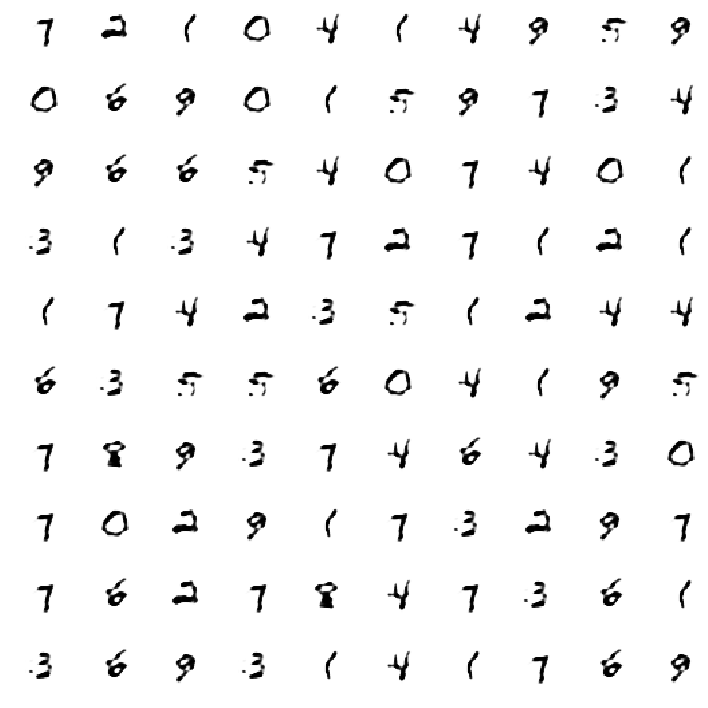

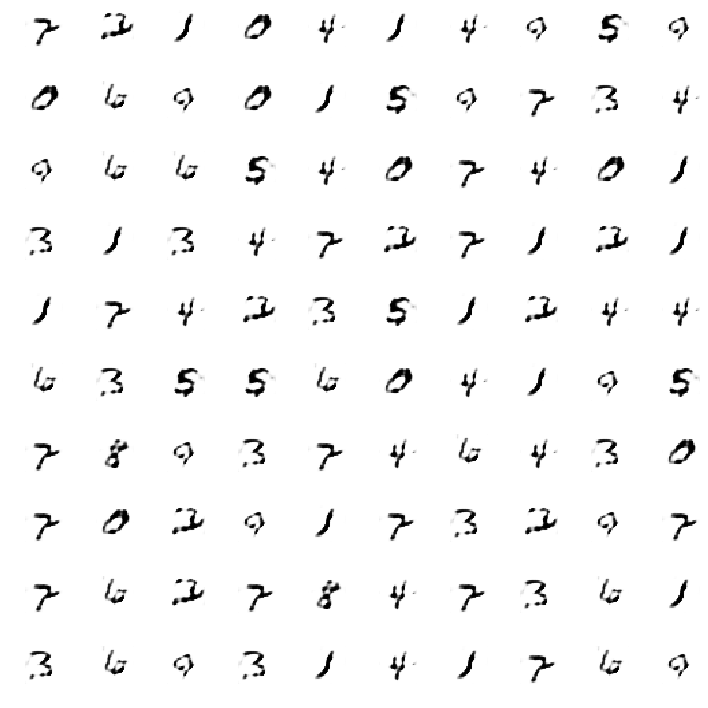

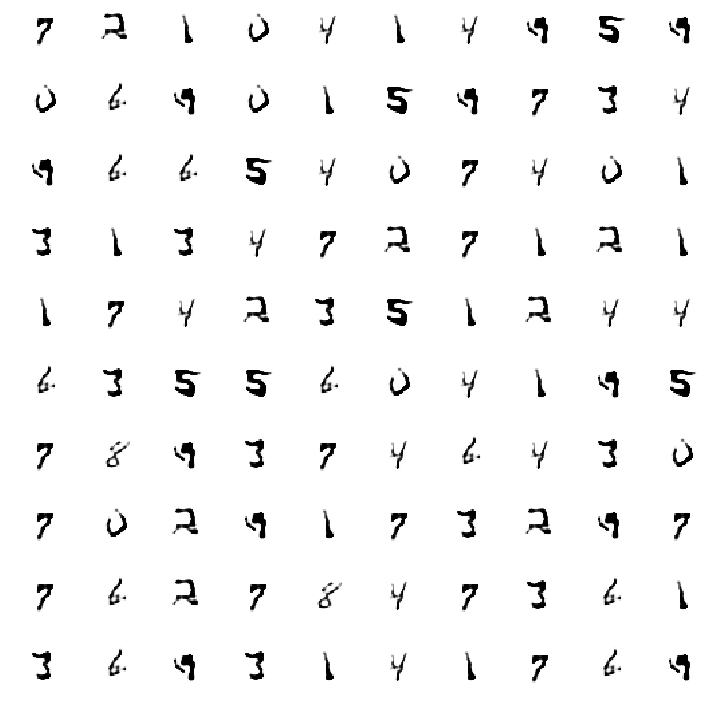

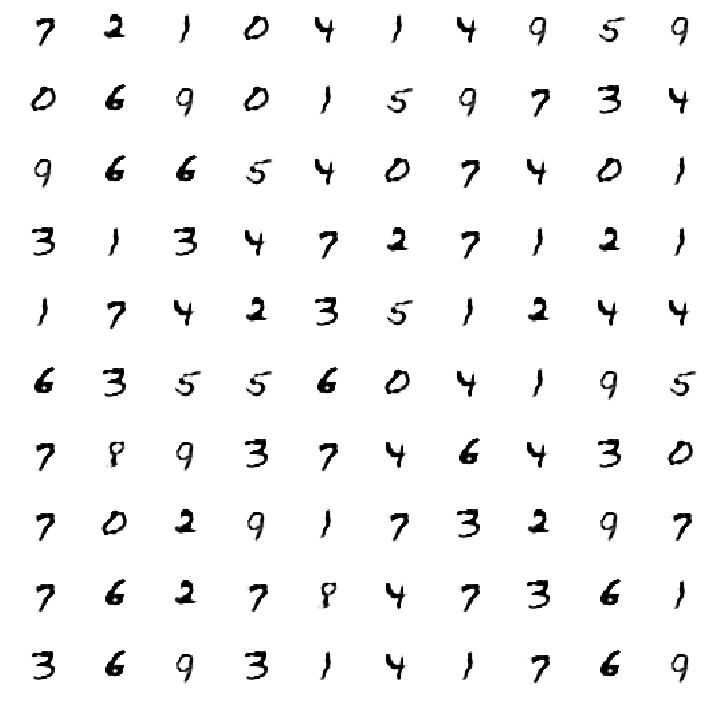

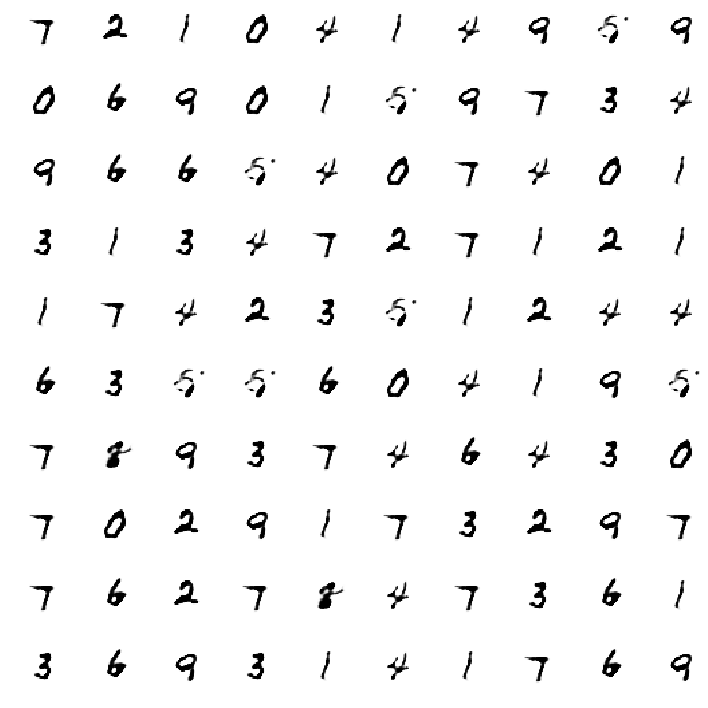

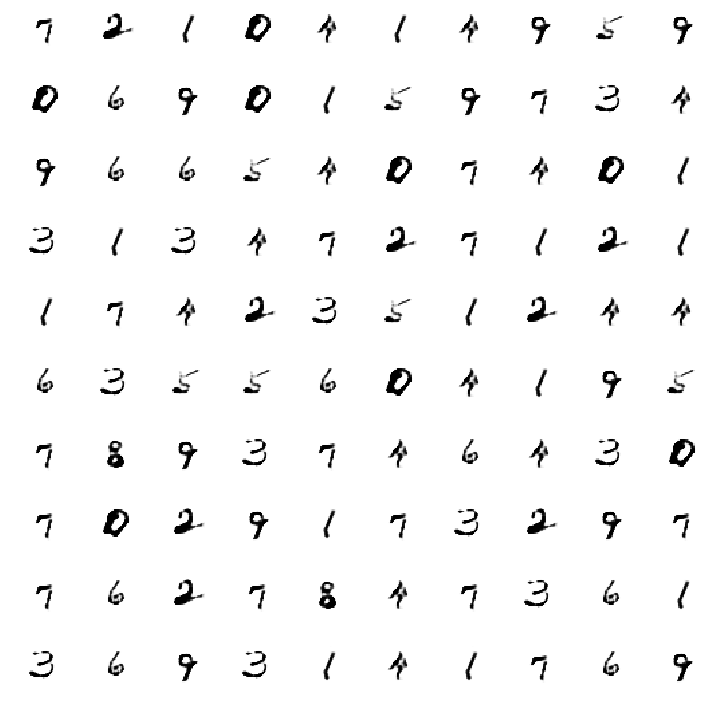

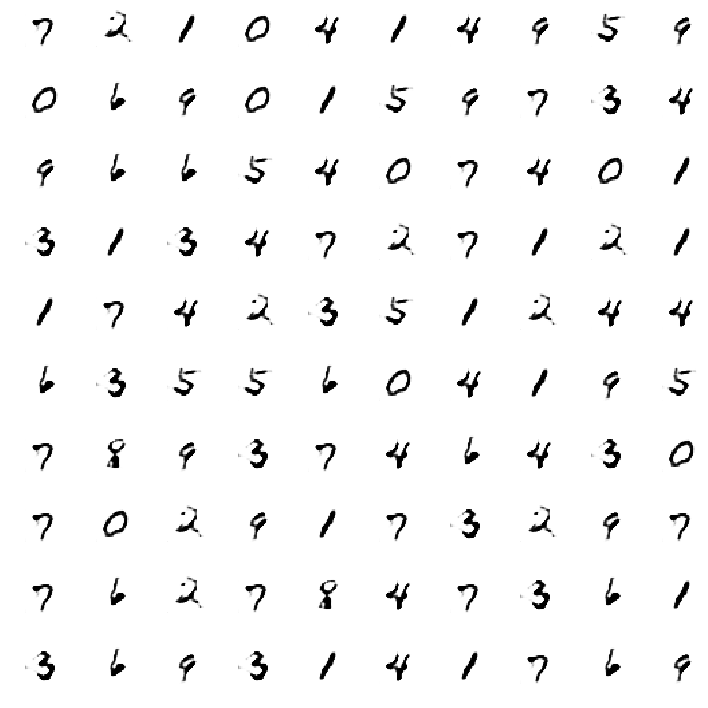

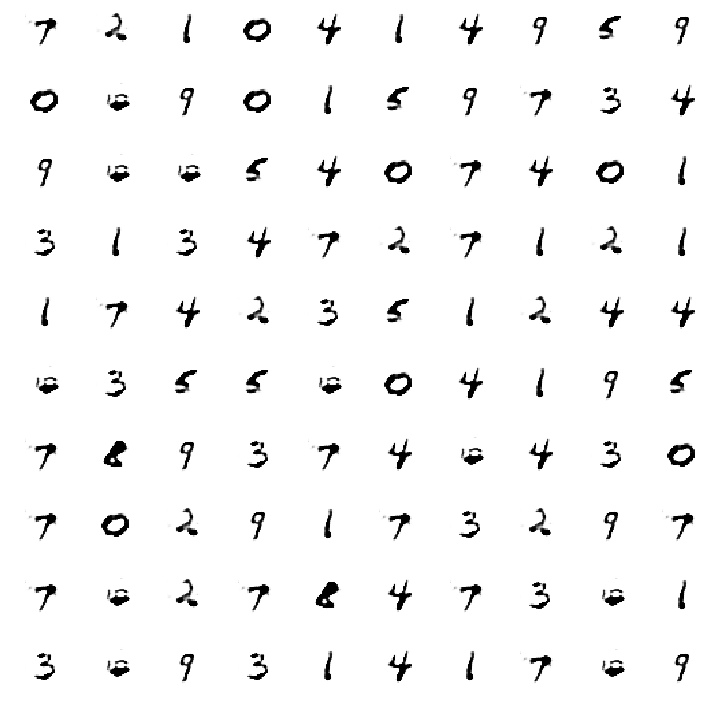

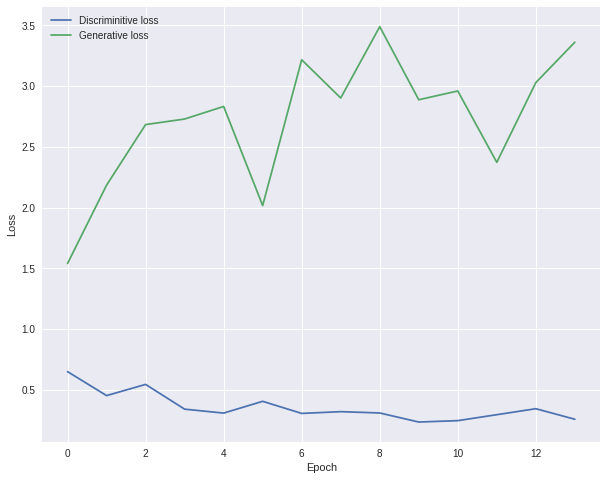

In [ ]:
if __name__ == '__main__':
    train(14, 128)

In [ ]:
from keras.models import load_model
discriminator=load_model('{}/dcgan_discriminator_epoch_12.h5'.format(model_folder))

/usr/local/lib/python2.7/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [ ]:
%matplotlib inline

In [ ]:
from keras.models import load_model
generator=load_model('{}/dcgan_generator_epoch_14.h5'.format(model_folder))

#INPUT

In [ ]:
l = []

x=word_to_num("four thousand seven hundred twenty three")

while x!=0:
  t = x%10
  x/=10
  l.append(t)
  
l=l[::-1]
l=np.asarray(l)


#OUTPUT




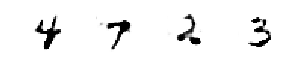

In [ ]:
generatedImages = generator.predict(to_categorical(l,inputDim))
dim=(28,28)

# plt.imshow(generatedImages[0, 0], interpolation='nearest', cmap='gray_r')
## To plot ###
dim=(10, 10)
figsize=(10, 10)

plt.figure(figsize=figsize)
for i in range(generatedImages.shape[0]):
    plt.subplot(10,10,i+1)
    plt.imshow(generatedImages[i, 0], interpolation='nearest', cmap='gray_r')
    plt.axis('off')
    
plt.tight_layout()
plt.show()

##Nothing

In [ ]:
batchSize =128

pickup_batch = np.random.randint(0, X_train.shape[0], size=batchSize) #selecting 128 random images out of 60k
our_input = to_categorical(y_train[pickup_batch],inputDim)   

In [ ]:
our_input.shape

(128, 10)

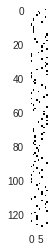

In [ ]:
plt.imshow(our_input)

In [ ]:
X_train.shape

(60000, 1, 28, 28)

In [ ]:
imageBatch = X_train[pickup_batch]
# plt.imshow(imageBatch[0])
imageBatch.shape

(128, 1, 28, 28)

In [ ]:
# Generate fake MNIST images
generatedImages = generator.predict(our_input) #UC

TypeError: ignored

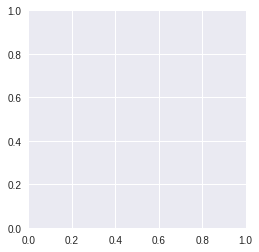

In [ ]:
plt.imshow(generatedImages)

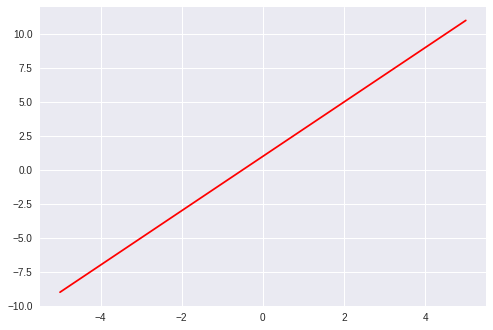

In [ ]:
x1 = np.linspace(-5,5,100)
y = 2*x1+1
img=plt.plot(x1, y, '-r', label='y=2x1+1')